In [1]:
#@title Only run this code if you need to install perch-hoplite

# For running in Colab (only if perch-hoplite is not installed)
# !pip install git+https://github.com/google-research/perch-hoplite.git

# For running locally
# Install perch-hoplite in your local environment (e.g. venv/conda) before running this notebook.


In [2]:
# @title Imports
from etils import epath
from IPython.display import display
import ipywidgets as widgets
import numpy as np
from perch_hoplite.agile import colab_utils
from perch_hoplite.agile import embed
from perch_hoplite.agile import source_info
from perch_hoplite.db import brutalism
from perch_hoplite.db import interface
import os

from matplotlib import pyplot as plt
import numpy as np

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import classifier_data
from perch_hoplite.agile import embedding_display
from perch_hoplite.agile import source_info
from perch_hoplite.db  import brutalism
from perch_hoplite.db import score_functions
from perch_hoplite.db  import search_results
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs


/Users/rodrigo/Desktop/CODES/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
import sys
print(sys.executable)

/Users/rodrigo/Desktop/CODES/.venv311/bin/python


In [4]:
# @title Configuration { vertical-output: true }

# @markdown Configure the raw dataset and output location(s).  The format is a mapping from
# @markdown a dataset_name to a (base_path, fileglob) pair.  Note that the file
# @markdown globs are case sensitive.  The dataset name can be anything you want.
#
# @markdown This structure allows you to move your data around without having to
# @markdown re-embed the dataset.  The generated embedding database will be
# @markdown placed in the base path. This allows you to simply swap out
# @markdown the base path here if you ever move your dataset.

# @markdown By default we only process one dataset at a time.  Re-run this entire notebook
# @markdown once per dataset.

# @markdown For example, we might set dataset_base_path to '/home/me/myproject',
# @markdown and use the glob '\*/\*.wav' if all of the audio files have filepaths
# @markdown like '/home/me/myproject/site_XYZ/audio_ABC.wav' (e.g. audio files are contained in subfolders of the base directory).

# -----------------------------
# PATHS (Local vs Colab)
# -----------------------------

# For running locally (Rod)
base_agile_path = epath.Path(
    "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile"
)

# For running in Colab
# from google.colab import drive
# drive.mount('/content/drive')
# base_agile_path = epath.Path("/content/drive/Shareddrives/MAR FUTURA/Agile")

# -----------------------------
# USER SETTINGS
# -----------------------------

# 1. Create a unique name for the database that will store the embeddings for the target data.
dataset_name = 'Data2'  # @param {type:'string'}

# 2. Input the filepath for the folder that is containing the input audio files.
dataset_base_path = str(base_agile_path / 'Data')  #@param {type:'string'}

# 3. Input the file pattern for the audio files within that folder that you want to embed.
dataset_fileglob = '*.wav'  # @param {type:'string'}

# 4. [Optional] If saving the embeddings database to a new directory, specify here.
db_path = ''  # @param {type:'string'}
if not db_path or db_path == 'None':
  db_path = None

# If you want a default DB location, keep this enabled.
if db_path is None:
  db_path = str(base_agile_path / 'Data')

# 5. Choose a supported model to generate embeddings.
model_choice = 'perch_8'  #@param['perch_v2','perch_8', 'humpback', 'multispecies_whale', 'surfperch', 'birdnet_V2.3']

# 6. [Optional] Shard the audio for embeddings.
use_file_sharding = True  # @param {type:'boolean'}
shard_length_in_seconds = 5  # @param {type:'number'}

audio_glob = source_info.AudioSourceConfig(
    dataset_name=dataset_name,
    base_path=dataset_base_path,
    file_glob=dataset_fileglob,
    min_audio_len_s=1.0,
    target_sample_rate_hz=-2,
    shard_len_s=float(shard_length_in_seconds) if use_file_sharding else None,
)

configs = colab_utils.load_configs(
    source_info.AudioSources((audio_glob,)),
    db_path,
    model_config_key=model_choice,
    db_key='sqlite_usearch',
)

# Correcting the model handle for surfperch
if model_choice == 'surfperch':
  configs.model_config.model_config.tfhub_path = 'google/surfperch/1'

# Convenience paths used later
query_uri_default = str(base_agile_path / 'Data' / 'boat.wav')
output_csv_default = str(base_agile_path / 'Data' / 'samples.csv')

print('dataset_base_path:', dataset_base_path)
print('db_path:', db_path)
print('query_uri_default:', query_uri_default)
print('output_csv_default:', output_csv_default)

configs


dataset_base_path: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data
db_path: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data
query_uri_default: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data/boat.wav
output_csv_default: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data/samples.csv


AgileConfigs(audio_sources_config=AudioSources(audio_globs=(AudioSourceConfig(dataset_name='Data2', base_path='/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data', file_glob='*.wav', min_audio_len_s=1.0, target_sample_rate_hz=-2, shard_len_s=5.0, max_shards_per_file=None),)), db_config=DBConfig(db_key='sqlite_usearch', db_config=db_path: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi
  unidad/Agile/Data
usearch_cfg:
  dtype: float16
  embedding_dim: 1280
  expansion_add: 256
  expansion_search: 128
  metric_name: IP
), model_config=ModelConfig(model_key='taxonomy_model_tf', embedding_dim=1280, model_config=hop_size_s: 5.0
model_path: ''
sample_rate: 32000
tfhub_path: google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier
tfhub_version: 8
window_size_s: 5.0
, logits_key=None, logits_idxes=None))

In [5]:
#@title Initialize the hoplite database (DB) { vertical-output: true }
global db
db = configs.db_config.load_db()
num_embeddings = db.count_embeddings()

print('Initialized DB located at ', configs.db_config.db_config.db_path)

def drop_and_reload_db(_) -> interface.HopliteDBInterface:
  db_path = epath.Path(configs.db_config.db_config.db_path)
  for fp in db_path.glob('hoplite.sqlite*'):
    fp.unlink()
  (db_path / 'usearch.index').unlink()
  print('\n Deleted previous db at: ', configs.db_config.db_config.db_path)
  db = configs.db_config.load_db()

#@markdown If `drop_existing_db` set to True, when the database already exists and contains embeddings,
#@markdown then those existing embeddings will be erased. You will be prompted to confirm you wish to delete those existing
#@markdown embeddings. If you want to keep existing embeddings in the database, then set to False, which will append the new
#@markdown embeddings to the database.
drop_existing_db = True  #@param {type:'boolean'}

if num_embeddings > 0 and drop_existing_db:
  print('Existing DB contains datasets: ', db.get_dataset_names())
  print('num embeddings: ', num_embeddings)
  print('\n\nClick the button below to confirm you really want to drop the database at ')
  print(f'{configs.db_config.db_config.db_path}\n')
  print(f'This will permanently delete all {num_embeddings} embeddings from the existing database.\n')
  print('If you do NOT want to delete this data, set `drop_existing_db` above to `False` and re-run this cell.\n')

  button = widgets.Button(description='Delete database?')
  button.on_click(drop_and_reload_db)
  display(button)

Initialized DB located at  /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Mi unidad/Agile/Data


AttributeError: 'SQLiteUSearchDB' object has no attribute 'get_dataset_names'

In [6]:
#@title Run the embedding { vertical-output: true }

print(f'Embedding dataset: {audio_glob.dataset_name}')

worker = embed.EmbedWorker(
    audio_sources=configs.audio_sources_config,
    db=db,
    model_config=configs.model_config)

worker.process_all(target_dataset_name=audio_glob.dataset_name)

print('\n\nEmbedding complete, total embeddings: ', db.count_embeddings())

Embedding dataset: Data2


100%|██████████| 11/11 [00:00<00:00, 2974.49it/s]




Embedding complete, total embeddings:  11


In [7]:
#@title Per dataset statistics { vertical-output: true }

if hasattr(db, 'get_dataset_names'):
  for dataset in db.get_dataset_names():
    print(f"\nDataset '{dataset}':")
    print('\tnum embeddings: ', db.get_embeddings_by_source(dataset, source_id=None).shape[0])
else:
  print('This perch-hoplite DB backend does not support get_dataset_names().')
  print('Total embeddings: ', db.count_embeddings())


This perch-hoplite DB backend does not support get_dataset_names().
Total embeddings:  11


In [8]:
#@title Load model and connect to database. { vertical-output: true }

#@markdown Location of database containing audio embeddings.
db_path = db_path  #@param {type:'string'}
#@markdown Identifier (eg, name) to attach to labels produced during validation.
annotator_id = 'Rod'  #@param {type:'string'}

# Load the DB using the config loader to avoid version-specific class names.
db = configs.db_config.load_db()

db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
if hasattr(embedding_model, 'window_size_s'):
  window_size_s = embedding_model.window_size_s
else:
  window_size_s = 5.0
audio_filepath_loader = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)


In [9]:
#@title Load query audio. { vertical-output: true }

#@markdown The `query_uri` can be a URL, filepath, or Xeno-Canto ID
#@markdown (like `xc777802`, containing an Eastern Whipbird (`easwhi1`)).
query_uri = query_uri_default  # @param {type:'string'}
query_label = 'boat'  # @param {type:'string'}

query = embedding_display.QueryDisplay(
    uri=query_uri, offset_s=0.0, window_size_s=5.0, sample_rate_hz=32000)
_ = query.display_interactive()


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='offset_s', max=5.0), Output…

In [10]:
#@title Embed the Query and Search. { vertical-output: true }

#@markdown Number of results to find and display.
num_results = 50  #@param
query_embedding = embedding_model.embed(
    query.get_audio_window()).embeddings[0, 0]

#@markdown If checked, search for examples
#@markdown near a particular target score.
target_sampling = False  #@param {type: 'boolean'}

#@markdown When target sampling, target this score.
target_score = -1.0  #@param
if not target_sampling:
  target_score = None

#@markdown If True, search the full DB. Otherwise, use approximate
#@markdown nearest-neighbor search.
exact_search = False  #@param {type: 'boolean'}

if exact_search:
  score_fn = score_functions.get_score_fn('dot', target_score=target_score)
  results, all_scores = brutalism.threaded_brute_search(
      db, query_embedding, num_results, score_fn=score_fn)
  # TODO(tomdenton): Better histogram when target sampling.
  _ = plt.hist(all_scores, bins=100)
  hit_scores = [r.sort_score for r in results.search_results]
  plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
              color='r', alpha=0.5)
else:
  ann_matches = db.ui.search(query_embedding, count=num_results)
  results = search_results.TopKSearchResults(top_k=num_results)
  for k, d in zip(ann_matches.keys, ann_matches.distances):
    results.update(search_results.SearchResult(k, d))

display(results) # Add this line to display the search results

2026-01-05 11:30:39.353858: I external/local_xla/xla/service/service.cc:163] XLA service 0xa84a8ae00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-05 11:30:39.353915: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-01-05 11:30:39.498748: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-05 11:30:39.506483: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1767623440.548585  197504 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TopKSearchResults(top_k=50, search_results=[SearchResult(window_id=np.uint64(4), sort_score=np.float32(-6.435115)), SearchResult(window_id=np.uint64(8), sort_score=np.float32(-6.2844796)), SearchResult(window_id=np.uint64(6), sort_score=np.float32(-5.6554556)), SearchResult(window_id=np.uint64(1), sort_score=np.float32(-5.226276)), SearchResult(window_id=np.uint64(3), sort_score=np.float32(-5.1188416)), SearchResult(window_id=np.uint64(2), sort_score=np.float32(-4.686492)), SearchResult(window_id=np.uint64(10), sort_score=np.float32(-4.493293)), SearchResult(window_id=np.uint64(7), sort_score=np.float32(-4.318879)), SearchResult(window_id=np.uint64(11), sort_score=np.float32(-4.014872)), SearchResult(window_id=np.uint64(9), sort_score=np.float32(-3.9218893)), SearchResult(window_id=np.uint64(5), sort_score=np.float32(-3.7335587))], _ids={np.uint64(1), np.uint64(2), np.uint64(3), np.uint64(4), np.uint64(5), np.uint64(6), np.uint64(7), np.uint64(8), np.uint64(9), np.uint64(10), np.uint64

Page 1 of 2
--------------------------------------------------------------------------------



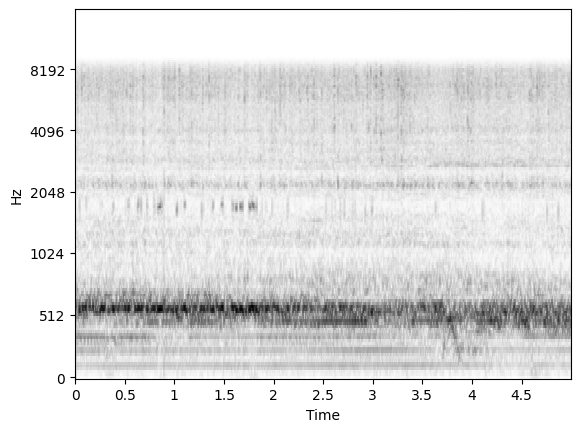

dataset name : Data2
source uri   : ZAPALLAR_20241122_143605_5sec.wav
offset_s     : 0.00
score        : -3.73


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


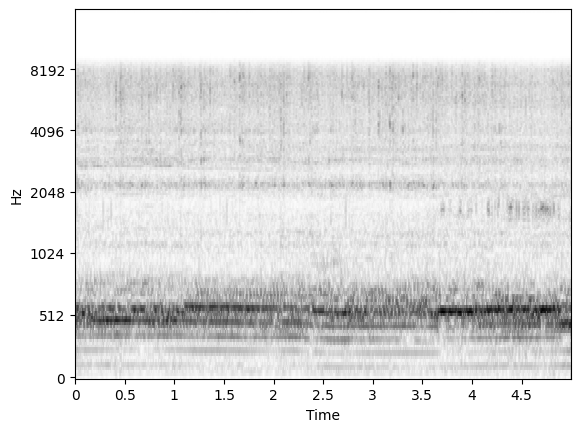

dataset name : Data2
source uri   : ZAPALLAR_20241122_143610_5sec.wav
offset_s     : 0.00
rank         : 1
score        : -3.92


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


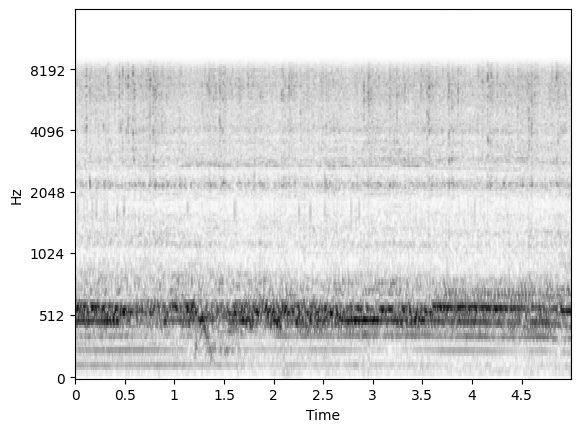

dataset name : Data2
source uri   : ZAPALLAR_20241122_143607_5sec.wav
offset_s     : 0.00
rank         : 2
score        : -4.01


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


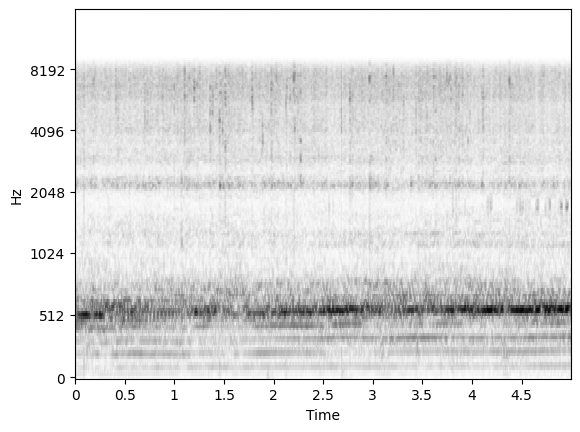

dataset name : Data2
source uri   : ZAPALLAR_20241122_143600_5sec.wav
offset_s     : 0.00
rank         : 3
score        : -4.32


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


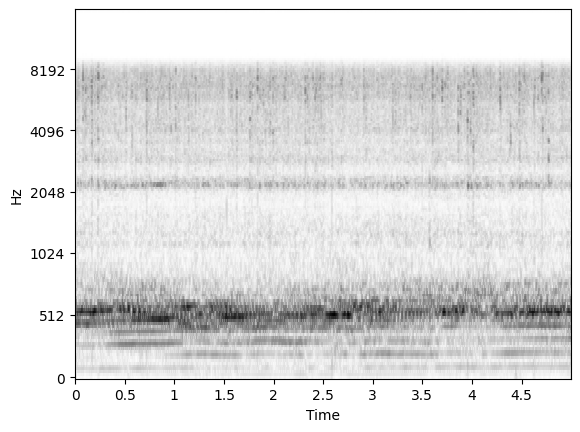

dataset name : Data2
source uri   : ZAPALLAR_20241122_143557_5sec.wav
offset_s     : 0.00
rank         : 4
score        : -4.49


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


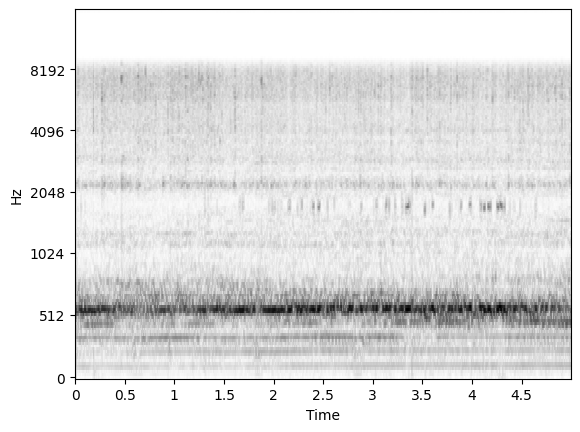

dataset name : Data2
source uri   : ZAPALLAR_20241122_143602_5sec.wav
offset_s     : 0.00
rank         : 5
score        : -4.69


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


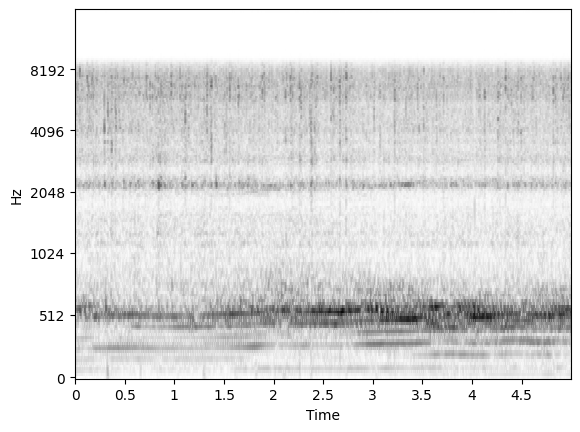

dataset name : Data2
source uri   : ZAPALLAR_20241122_143555_5sec.wav
offset_s     : 0.00
rank         : 6
score        : -5.12


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


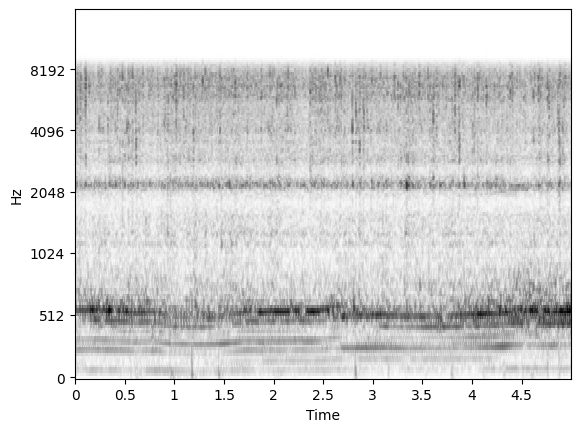

dataset name : Data2
source uri   : ZAPALLAR_20241122_143552_5sec.wav
offset_s     : 0.00
rank         : 7
score        : -5.23


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


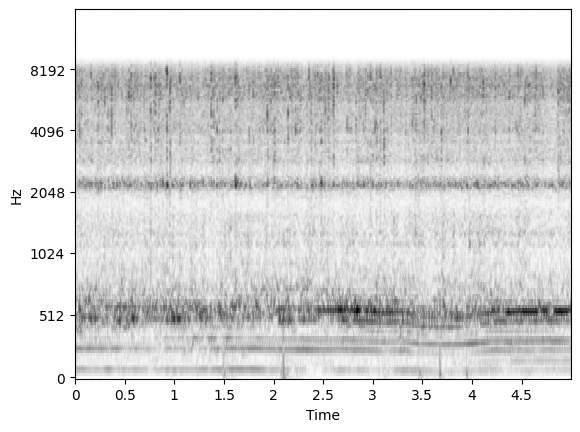

dataset name : Data2
source uri   : ZAPALLAR_20241122_143550_5sec.wav
offset_s     : 0.00
rank         : 8
score        : -5.66


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------


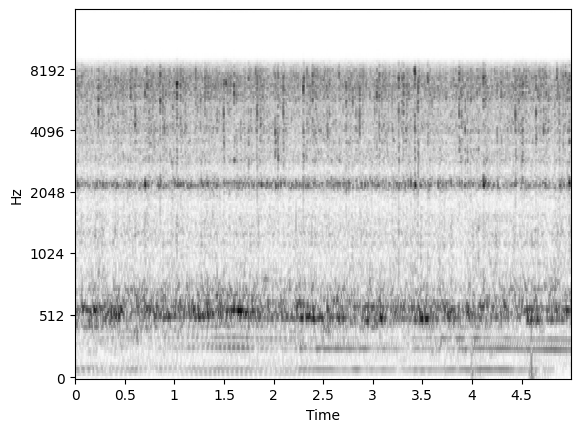

dataset name : Data2
source uri   : ZAPALLAR_20241122_143547_5sec.wav
offset_s     : 0.00
rank         : 9
score        : -6.28


GridspecLayout(children=(Button(description='boat', layout=Layout(grid_area='widget001'), style=ButtonStyle())…


--------------------------------------------------------------------------------
Page 1 of 2


Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [11]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[query_label])

In [ ]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)

# ***Classify***

In [ ]:
#@title Classifier training. { vertical-output: true }

#@markdown Set of labels to classify. If None, auto-populated from the DB.
target_labels = "boat"  #@param {type:"string"}
if target_labels:
  target_labels = [label.strip() for label in target_labels.split(',') if label.strip()]
else:
    target_labels = None


#@markdown Classifier traning hyperparams. These should not require tuning.
learning_rate = 1e-3  #@param
weak_neg_weight = 0.05  #@param
l2_mu = 0.000  #@param
num_steps = 128  #@param

train_ratio = 0.9  #@param
batch_size = 128  #@param
weak_negatives_batch_size = 128  #@param
loss_fn_name = 'bce'  #@param ['hinge', 'bce']

data_manager = classifier_data.AgileDataManager(
    target_labels=target_labels,
    db=db,
    train_ratio=train_ratio,
    min_eval_examples=1,
    batch_size=batch_size,
    weak_negatives_batch_size=weak_negatives_batch_size,
    rng=np.random.default_rng(seed=5))

print('Training for target labels : ')
print(data_manager.get_target_labels())
linear_classifier, eval_scores = classifier.train_linear_classifier(
    data_manager=data_manager,
    learning_rate=learning_rate,
    weak_neg_weight=weak_neg_weight,
    num_train_steps=num_steps,
)
print('\n' + '-' * 80)
top1 = eval_scores['top1_acc']
print(f'top-1      {top1:.3f}')
rocauc = eval_scores['roc_auc']
print(f'roc_auc    {rocauc:.3f}')
cmap = eval_scores['cmap']
print(f'cmap       {cmap:.3f}')

# Save linear classifier.
linear_classifier.save(os.path.join(db_path, 'agile_classifier_v2.pt'))

In [ ]:
#@title Review Classifier Results. { vertical-output: true }

#@markdown Number of results to find and display.
target_label = 'boat'  #@param {type:'string'}
num_results = 50  #@param

target_label_idx = data_manager.get_target_labels().index(target_label)
class_query = linear_classifier.beta[:, target_label_idx]
bias = linear_classifier.beta_bias[target_label_idx]

#@markdown Number of (randomly selected) database entries to search over.
sample_size = 1_000_000  #@param

#@markdown Whether to use margin-sampling. If checked, search for examples
#@markdown with logits near a particular target score (usually 0).
margin_sampling = False  #@param {type: 'boolean'}

#@markdown When margin sampling, target this logit.
margin_target_score = -0.0  #@param
if not margin_sampling:
  margin_target_score = None
score_fn = score_functions.get_score_fn(
    'dot', bias=bias, target_score=margin_target_score)
results, all_scores = brutalism.threaded_brute_search(
    db, class_query, num_results, score_fn=score_fn,
    sample_size=sample_size)

# TODO(tomdenton): Better histogram when margin sampling.
_ = plt.hist(all_scores, bins=100)
hit_scores = [r.sort_score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)


In [ ]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[target_label])

In [ ]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)

In [ ]:
#@title Run inference with trained classifier. { vertical-output: true }

output_csv_filepath = output_csv_default  #@param {type:'string'}
logit_threshold = 2  #@param
# Set labels to a tuple of desired labels if you want to run inference on a
# subset of the labels.
labels = None  #@param

classifier.write_inference_csv(
    linear_classifier, db, output_csv_filepath, logit_threshold, labels=labels)
